# Phantom ->  Simulated CT -> CAD Pipeline

The purpose of this notebook is to display the whole pipeline for a single 5 mm slice.

A few additional libraries are required to run the notebook, run the following in your terminal then restart the notebook:

```shell
pip install git+https://github.com/DIDSR/InSilicoICH
pip install -q ipywidgets
```

### Phantom creation module

In [ ]:
from VITools import get_available_phantoms
available_phantoms = get_available_phantoms()
available_phantoms

/scratch/brandon.nelson/miniconda3/envs/synthetic-ich-for-cad-evaluations/lib/python3.11/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


{'Water Phantom': VITools.examples.WaterPhantom,
 '0.0 yr UNC Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.UNC_Head'>, age=0.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/UNC_Head_phantom')),
 '1.0 yr UNC Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.UNC_Head'>, age=1.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/UNC_Head_phantom')),
 '2.0 yr UNC Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.UNC_Head'>, age=2.0, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/UNC_Head_phantom')),
 '6.5 yr NIHPD Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.NIHPD_Head'>, age=6.5, phantom_dir=PosixPath('/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/phantoms/NIHPD_Head_Phantom')),
 '9.0 yr NIHPD Head': functools.partial(<class 'insilicoICH.phantoms.head_phantoms.NIHPD_Head'>, age=9.0, phantom_dir=Pos

In [ ]:
from image_utils import scrollview
from insilicoICH.lesion_definition import LesionFactory

name = '15.75 yr NIHPD Head'
seed=42
subtype='IPH'
volume=5
attenuation=50
if subtype == 'IPH':
    edema=5
else:
    edema=0

phantom = available_phantoms[name]()

lesion = LesionFactory.create(subtype, spacings=phantom.spacings, boundary=phantom.get_material_mask('white matter'), seed=42)
lesion.generate(volume_ml=volume, intensity_hu=attenuation, edema_thickness=edema)
phantom.insert_lesion(lesion, mass_effect=0.5)

scrollview(phantom.get_CT_number_phantom(), display='soft tissues')

pseudo-CT images not found; defaulting to otsu segmentation method


interactive(children=(IntSlider(value=94, description='idx', max=188), Output()), _dom_classes=('widget-intera…

# Scanner module

Initializing Scanner object...
----------
* Calculating volume fraction maps for 4 materials and 189 slices...
* Writing volume fraction files for 4 materials and 189 slices, plus HU data...
* Writing /tmp/tmp1whee5ru/15.75 yr NIHPD Head/phantoms/0/0_ncat_adipose_197x233x189.raw...
* Writing /tmp/tmp1whee5ru/15.75 yr NIHPD Head/phantoms/0/0_ncat_water_197x233x189.raw...
* Writing /tmp/tmp1whee5ru/15.75 yr NIHPD Head/phantoms/0/0_ncat_brain_197x233x189.raw...
* Writing /tmp/tmp1whee5ru/15.75 yr NIHPD Head/phantoms/0/0_ncat_skull_197x233x189.raw...
* Writing /tmp/tmp1whee5ru/15.75 yr NIHPD Head/phantoms/0/0_HU_data_197x233x189.raw...
* Writing /tmp/tmp1whee5ru/15.75 yr NIHPD Head/phantoms/0/0.json...
Scanner Ready
36.37894736842105


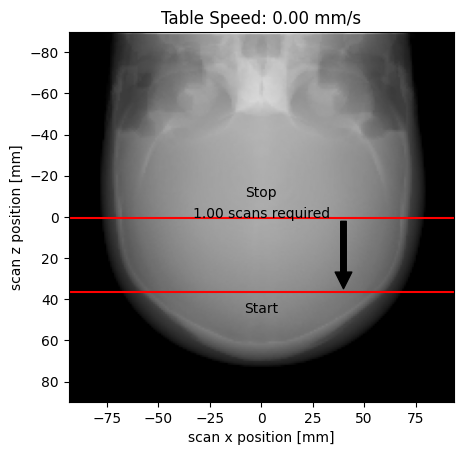

In [ ]:
from VITools import Scanner
scanner = Scanner(phantom, scanner_model='GE_Lightspeed64')

scans = 1
lesion_level_mm = (phantom.get_CT_number_phantom().shape[0]/2 - phantom.lesions[0].coords_voxel[0])*phantom.dz
center = lesion_level_mm
width = scanner.nominal_aperature*scans
print(width)
startZ = center - width / 2
endZ = center + width / 2

# startZ, endZ = scanner.recommend_scan_range()

scanner.scout_view(startZ, endZ)

In [ ]:
from pathlib import Path
outdir = Path('result') / name


In [ ]:
import SimpleITK as sitk
acquisition_technique = dict(
    mA=280,
    kVp=120,
    views=500,
    startZ=startZ,
    endZ=endZ,
    pitch=0
)

recon_technique = dict(
    kernel='standard',
    fov=250,
    slice_thickness=1, # 5mm slice thickness currently does not work as intended
    slice_increment=1
)

if outdir.exists():
    scanner.recon = sitk.GetArrayFromImage(sitk.ReadImage(list(outdir.glob('*.dcm'))))
else:
    scanner.run_scan(**acquisition_technique)
    scanner.run_recon(**recon_technique)
    scanner.write_to_dicom(outdir/'test.dcm')

ImageSeriesReader (0xebfa1f0): Non uniform sampling or missing slices detected,  maximum nonuniformity:22.8214



In [ ]:
scrollview(scanner.recon, (100, 50))

interactive(children=(IntSlider(value=14, description='idx', max=28), Output()), _dom_classes=('widget-interac…